In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle


from tensorflow.keras.layers import Dropout,MultiHeadAttention,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate
from tensorflow.keras import callbacks 

from sklearn.model_selection import KFold

In [44]:
os.getcwd() 

'D:\\code\\Fiona\\climate project\\New Data\\sza60'

In [2]:
#retrieve data
num = 4000 # number of profiles
nvza = 12 # number of channels
nsza=6

s = 82 # output slice size
ts = 82 # input slice size 

In [3]:
#get the averaged reflectance from the dataset 
r=np.load('all_angles_r.npy')
c=np.load('cot_500m.npy')

In [4]:
r.shape

(4000, 82, 6, 12)

In [5]:
r=r.reshape((4000,82,72))

In [6]:
r.shape

(4000, 82, 72)

In [7]:
c.shape

(4000, 82)

In [8]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.


In [9]:

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800
print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')




train_size: 3200 profiles
test_size: 800 profiles


In [10]:
ltype = 'mean_squared_error'
type2=tf.keras.metrics.RootMeanSquaredError()
bsize = 16
eps = 2000




In [11]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

NameError: name 'model' is not defined

In [12]:
import os
checkpoint_path = "training_all_v2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [20]:


def eval_model(train_image, test_image, train_label, test_label):

    #bi-LSTM
    input_layer = tf.keras.layers.Input(shape=(82,72),name='Input') #82,72
    #patch embedding layer
    #The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim
    projection=tf.keras.layers.Dense(64,activation='relu')(input_layer)
    positions = tf.range(start=0, limit=82, delta=1)
    embedding=tf.keras.layers.Embedding(input_dim=(82),output_dim=(64),input_length=128)(positions)
    # adds a learnable position embedding to the projected vector
    encoded = projection+embedding

    bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True))(encoded) #kernel size 6, 100 filters for each 3 channel
    bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True))(bi) #kernel size 6, 100 filters for each 3 input_layerchannel


    #transformer block
    slf_attn = MultiHeadAttention(num_heads=3,key_dim=3)(bi,bi)
    add1=tf.keras.layers.Add()([slf_attn,bi])
    layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add1)
    dense1=tf.keras.layers.Dense(256,activation='relu')(layernorm1)
    add2=tf.keras.layers.Add()([layernorm1,dense1])
    layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add2)
    
    
    
    flat=tf.keras.layers.Flatten()(layernorm2)

    #pooling
   # avg_pool = GlobalAveragePooling1D()(layernorm2)
  #  max_pool = GlobalMaxPooling1D()(layernorm2)
   # conc = concatenate([avg_pool, max_pool])

    #output layers
   # dense2 = tf.keras.layers.Dense(42*3,activation='relu')(conc)
    drop=tf.keras.layers.Dropout(.2)(flat)

    output = tf.keras.layers.Dense(82,activation='relu')(drop)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])

    model.summary()
    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.25,
                              callbacks =[earlystopping,cp_callback])
    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]
    
    return model,rmse,mse,history,predictions,results

In [21]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds)

X_train=np.zeros((5,800*4,ts,72))
y_train=np.zeros((5,ratio*(n_folds-1),82))
X_test=np.zeros((n_folds,ratio,ts,72))
y_test=np.zeros((n_folds,ratio,82))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index]
    y_train[count], y_test[count] = c[train_index], c[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 800  801  802 ... 3997 3998 3999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [3200 3201 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213
 3214 3215 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227
 3228 3229 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241
 3242 3243 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253 3254 3255
 3256 3257 3258 3259 3260 3261 3262 3263 3264 3265 3266 3267 3268 3269
 3270 3271 3272 3273 3274 3275 3276 3277 3278 3279 3280 3281 3282 3283
 3284 3285 3286 3287 3288 3289 3290 3291 3292 3293 3294 3295 3296 3297
 3298 3299 3300 3301 3302 3303 3304 3305 3306 3307 3308 3309 3310 3311
 3312 3313 3314 3315 3316 3317 3318 3319 3320 3321 3322 3323 3324 3325
 3326 3327 3328 3329 3330 3331 3332 3333 3334 3335 3336 3337 3338 3339
 3340 3341 3342 3343 3344 3345 3346 3347 3348 3349 3350 3351 3352 3353
 3354 3355 3356 3357 3358 3359 3360 3361 3362 3363 3364 3365 3366 3367
 3368 3369 3370 3371 3372 3373 3374 3375 3376 3377 3378 3379 3380 3381
 3382 3383 3384 3385 3386 33

In [22]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions,results= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)




   



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 82, 72)]     0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 82, 64)       4672        Input[0][0]                      
__________________________________________________________________________________________________
tf.__operators__.add_2 (TFOpLam (None, 82, 64)       0           dense_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 82, 256)      197632      tf.__operators__.add_2[0][0]     
______________________________________________________________________________________________

150/150 [==============================] - 4s 30ms/step - loss: 3.0479 - mean_squared_error: 3.0479 - root_mean_squared_error: 1.7451 - val_loss: 2.8834 - val_mean_squared_error: 2.8834 - val_root_mean_squared_error: 1.6980

Epoch 00017: saving model to training_all_v2\cp.ckpt
Epoch 18/2000
150/150 [==============================] - 4s 30ms/step - loss: 2.9291 - mean_squared_error: 2.9291 - root_mean_squared_error: 1.7109 - val_loss: 2.7850 - val_mean_squared_error: 2.7850 - val_root_mean_squared_error: 1.6688

Epoch 00018: saving model to training_all_v2\cp.ckpt
Epoch 19/2000
150/150 [==============================] - 4s 30ms/step - loss: 2.9484 - mean_squared_error: 2.9484 - root_mean_squared_error: 1.7168 - val_loss: 2.7334 - val_mean_squared_error: 2.7334 - val_root_mean_squared_error: 1.6533

Epoch 00019: saving model to training_all_v2\cp.ckpt
Epoch 20/2000
150/150 [==============================] - 4s 30ms/step - loss: 3.1010 - mean_squared_error: 3.1010 - root_mean_squared_erro

150/150 [==============================] - 4s 30ms/step - loss: 0.2599 - mean_squared_error: 0.2599 - root_mean_squared_error: 0.5098 - val_loss: 0.1632 - val_mean_squared_error: 0.1632 - val_root_mean_squared_error: 0.4040

Epoch 00045: saving model to training_all_v2\cp.ckpt
Epoch 46/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.2580 - mean_squared_error: 0.2580 - root_mean_squared_error: 0.5079 - val_loss: 0.1764 - val_mean_squared_error: 0.1764 - val_root_mean_squared_error: 0.4200

Epoch 00046: saving model to training_all_v2\cp.ckpt
Epoch 47/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.2681 - mean_squared_error: 0.2681 - root_mean_squared_error: 0.5176 - val_loss: 0.2891 - val_mean_squared_error: 0.2891 - val_root_mean_squared_error: 0.5377

Epoch 00047: saving model to training_all_v2\cp.ckpt
Epoch 48/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.2613 - mean_squared_error: 0.2613 - root_mean_squared_erro

150/150 [==============================] - 4s 30ms/step - loss: 0.1981 - mean_squared_error: 0.1981 - root_mean_squared_error: 0.4450 - val_loss: 0.1331 - val_mean_squared_error: 0.1331 - val_root_mean_squared_error: 0.3649

Epoch 00073: saving model to training_all_v2\cp.ckpt
Epoch 74/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1802 - mean_squared_error: 0.1802 - root_mean_squared_error: 0.4245 - val_loss: 0.1165 - val_mean_squared_error: 0.1165 - val_root_mean_squared_error: 0.3413

Epoch 00074: saving model to training_all_v2\cp.ckpt
Epoch 75/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1873 - mean_squared_error: 0.1873 - root_mean_squared_error: 0.4327 - val_loss: 0.1286 - val_mean_squared_error: 0.1286 - val_root_mean_squared_error: 0.3586

Epoch 00075: saving model to training_all_v2\cp.ckpt
Epoch 76/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.2046 - mean_squared_error: 0.2046 - root_mean_squared_erro

150/150 [==============================] - 4s 30ms/step - loss: 0.1671 - mean_squared_error: 0.1671 - root_mean_squared_error: 0.4088 - val_loss: 0.0897 - val_mean_squared_error: 0.0897 - val_root_mean_squared_error: 0.2995

Epoch 00101: saving model to training_all_v2\cp.ckpt
Epoch 102/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1751 - mean_squared_error: 0.1751 - root_mean_squared_error: 0.4183 - val_loss: 0.1333 - val_mean_squared_error: 0.1333 - val_root_mean_squared_error: 0.3651

Epoch 00102: saving model to training_all_v2\cp.ckpt
Epoch 103/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1774 - mean_squared_error: 0.1774 - root_mean_squared_error: 0.4211 - val_loss: 0.0978 - val_mean_squared_error: 0.0978 - val_root_mean_squared_error: 0.3127

Epoch 00103: saving model to training_all_v2\cp.ckpt
Epoch 104/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1649 - mean_squared_error: 0.1649 - root_mean_squared_e

150/150 [==============================] - 5s 30ms/step - loss: 0.1704 - mean_squared_error: 0.1704 - root_mean_squared_error: 0.4128 - val_loss: 0.1114 - val_mean_squared_error: 0.1114 - val_root_mean_squared_error: 0.3338

Epoch 00129: saving model to training_all_v2\cp.ckpt
Epoch 130/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1600 - mean_squared_error: 0.1600 - root_mean_squared_error: 0.4000 - val_loss: 0.0920 - val_mean_squared_error: 0.0920 - val_root_mean_squared_error: 0.3033

Epoch 00130: saving model to training_all_v2\cp.ckpt
Epoch 131/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1625 - mean_squared_error: 0.1625 - root_mean_squared_error: 0.4031 - val_loss: 0.0894 - val_mean_squared_error: 0.0894 - val_root_mean_squared_error: 0.2989

Epoch 00131: saving model to training_all_v2\cp.ckpt
Epoch 132/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1528 - mean_squared_error: 0.1528 - root_mean_squared_e

150/150 [==============================] - 4s 29ms/step - loss: 0.1488 - mean_squared_error: 0.1488 - root_mean_squared_error: 0.3857 - val_loss: 0.0798 - val_mean_squared_error: 0.0798 - val_root_mean_squared_error: 0.2824

Epoch 00157: saving model to training_all_v2\cp.ckpt
Epoch 158/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1476 - mean_squared_error: 0.1476 - root_mean_squared_error: 0.3841 - val_loss: 0.0928 - val_mean_squared_error: 0.0928 - val_root_mean_squared_error: 0.3046

Epoch 00158: saving model to training_all_v2\cp.ckpt
Epoch 159/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1585 - mean_squared_error: 0.1585 - root_mean_squared_error: 0.3981 - val_loss: 0.1003 - val_mean_squared_error: 0.1003 - val_root_mean_squared_error: 0.3167

Epoch 00159: saving model to training_all_v2\cp.ckpt
Epoch 160/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1543 - mean_squared_error: 0.1543 - root_mean_squared_e

150/150 [==============================] - 12s 42ms/step - loss: 71.9976 - mean_squared_error: 71.9976 - root_mean_squared_error: 5.7680 - val_loss: 25.7367 - val_mean_squared_error: 25.7367 - val_root_mean_squared_error: 5.0731

Epoch 00001: saving model to training_all_v2\cp.ckpt
Epoch 2/2000
150/150 [==============================] - 4s 29ms/step - loss: 22.8734 - mean_squared_error: 22.8734 - root_mean_squared_error: 4.7813 - val_loss: 19.0318 - val_mean_squared_error: 19.0318 - val_root_mean_squared_error: 4.3625

Epoch 00002: saving model to training_all_v2\cp.ckpt
Epoch 3/2000
150/150 [==============================] - 4s 28ms/step - loss: 17.4442 - mean_squared_error: 17.4442 - root_mean_squared_error: 4.1762 - val_loss: 16.5636 - val_mean_squared_error: 16.5636 - val_root_mean_squared_error: 4.0698

Epoch 00003: saving model to training_all_v2\cp.ckpt
Epoch 4/2000
150/150 [==============================] - 4s 29ms/step - loss: 15.3438 - mean_squared_error: 15.3438 - root_mean_

150/150 [==============================] - 4s 29ms/step - loss: 3.1621 - mean_squared_error: 3.1621 - root_mean_squared_error: 1.7777 - val_loss: 3.4120 - val_mean_squared_error: 3.4120 - val_root_mean_squared_error: 1.8472

Epoch 00029: saving model to training_all_v2\cp.ckpt
Epoch 30/2000
150/150 [==============================] - 4s 29ms/step - loss: 3.1870 - mean_squared_error: 3.1870 - root_mean_squared_error: 1.7842 - val_loss: 3.3468 - val_mean_squared_error: 3.3468 - val_root_mean_squared_error: 1.8294

Epoch 00030: saving model to training_all_v2\cp.ckpt
Epoch 31/2000
150/150 [==============================] - 4s 29ms/step - loss: 3.0107 - mean_squared_error: 3.0107 - root_mean_squared_error: 1.7330 - val_loss: 3.3579 - val_mean_squared_error: 3.3579 - val_root_mean_squared_error: 1.8325

Epoch 00031: saving model to training_all_v2\cp.ckpt
Epoch 32/2000
150/150 [==============================] - 4s 29ms/step - loss: 3.2908 - mean_squared_error: 3.2908 - root_mean_squared_erro

150/150 [==============================] - 4s 29ms/step - loss: 3.2449 - mean_squared_error: 3.2449 - root_mean_squared_error: 1.8007 - val_loss: 3.2989 - val_mean_squared_error: 3.2989 - val_root_mean_squared_error: 1.8163

Epoch 00057: saving model to training_all_v2\cp.ckpt
Epoch 58/2000
150/150 [==============================] - 4s 29ms/step - loss: 2.8717 - mean_squared_error: 2.8717 - root_mean_squared_error: 1.6932 - val_loss: 3.3851 - val_mean_squared_error: 3.3851 - val_root_mean_squared_error: 1.8399

Epoch 00058: saving model to training_all_v2\cp.ckpt
Epoch 59/2000
150/150 [==============================] - 4s 29ms/step - loss: 3.0684 - mean_squared_error: 3.0684 - root_mean_squared_error: 1.7515 - val_loss: 3.3230 - val_mean_squared_error: 3.3230 - val_root_mean_squared_error: 1.8229

Epoch 00059: saving model to training_all_v2\cp.ckpt
Epoch 60/2000
150/150 [==============================] - 4s 29ms/step - loss: 3.2462 - mean_squared_error: 3.2462 - root_mean_squared_erro

150/150 [==============================] - 4s 29ms/step - loss: 0.1749 - mean_squared_error: 0.1749 - root_mean_squared_error: 0.4182 - val_loss: 0.1227 - val_mean_squared_error: 0.1227 - val_root_mean_squared_error: 0.3503

Epoch 00085: saving model to training_all_v2\cp.ckpt
Epoch 86/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1825 - mean_squared_error: 0.1825 - root_mean_squared_error: 0.4271 - val_loss: 0.1111 - val_mean_squared_error: 0.1111 - val_root_mean_squared_error: 0.3333

Epoch 00086: saving model to training_all_v2\cp.ckpt
Epoch 87/2000
150/150 [==============================] - 4s 28ms/step - loss: 0.1874 - mean_squared_error: 0.1874 - root_mean_squared_error: 0.4328 - val_loss: 0.1331 - val_mean_squared_error: 0.1331 - val_root_mean_squared_error: 0.3648

Epoch 00087: saving model to training_all_v2\cp.ckpt
Epoch 88/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1806 - mean_squared_error: 0.1806 - root_mean_squared_erro

150/150 [==============================] - 4s 30ms/step - loss: 0.1627 - mean_squared_error: 0.1627 - root_mean_squared_error: 0.4034 - val_loss: 0.0914 - val_mean_squared_error: 0.0914 - val_root_mean_squared_error: 0.3023

Epoch 00113: saving model to training_all_v2\cp.ckpt
Epoch 114/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1645 - mean_squared_error: 0.1645 - root_mean_squared_error: 0.4055 - val_loss: 0.0935 - val_mean_squared_error: 0.0935 - val_root_mean_squared_error: 0.3058

Epoch 00114: saving model to training_all_v2\cp.ckpt
Epoch 115/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1608 - mean_squared_error: 0.1608 - root_mean_squared_error: 0.4010 - val_loss: 0.1151 - val_mean_squared_error: 0.1151 - val_root_mean_squared_error: 0.3393

Epoch 00115: saving model to training_all_v2\cp.ckpt
Epoch 116/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1596 - mean_squared_error: 0.1596 - root_mean_squared_e

Epoch 141/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1509 - mean_squared_error: 0.1509 - root_mean_squared_error: 0.3884 - val_loss: 0.0857 - val_mean_squared_error: 0.0857 - val_root_mean_squared_error: 0.2927

Epoch 00141: saving model to training_all_v2\cp.ckpt
Epoch 142/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1406 - mean_squared_error: 0.1406 - root_mean_squared_error: 0.3750 - val_loss: 0.0724 - val_mean_squared_error: 0.0724 - val_root_mean_squared_error: 0.2691

Epoch 00142: saving model to training_all_v2\cp.ckpt
Epoch 143/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1466 - mean_squared_error: 0.1466 - root_mean_squared_error: 0.3829 - val_loss: 0.1134 - val_mean_squared_error: 0.1134 - val_root_mean_squared_error: 0.3368

Epoch 00143: saving model to training_all_v2\cp.ckpt
Epoch 144/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1512 - mean_squared_error: 0.1512 - root

150/150 [==============================] - 4s 29ms/step - loss: 0.1391 - mean_squared_error: 0.1391 - root_mean_squared_error: 0.3729 - val_loss: 0.0885 - val_mean_squared_error: 0.0885 - val_root_mean_squared_error: 0.2975

Epoch 00169: saving model to training_all_v2\cp.ckpt
Epoch 170/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1355 - mean_squared_error: 0.1355 - root_mean_squared_error: 0.3681 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - val_root_mean_squared_error: 0.2604

Epoch 00170: saving model to training_all_v2\cp.ckpt
Epoch 171/2000
150/150 [==============================] - 5s 30ms/step - loss: 0.1451 - mean_squared_error: 0.1451 - root_mean_squared_error: 0.3809 - val_loss: 0.0726 - val_mean_squared_error: 0.0726 - val_root_mean_squared_error: 0.2694

Epoch 00171: saving model to training_all_v2\cp.ckpt
Epoch 172/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1366 - mean_squared_error: 0.1366 - root_mean_squared_e

150/150 [==============================] - 4s 29ms/step - loss: 0.1302 - mean_squared_error: 0.1302 - root_mean_squared_error: 0.3609 - val_loss: 0.0668 - val_mean_squared_error: 0.0668 - val_root_mean_squared_error: 0.2585

Epoch 00197: saving model to training_all_v2\cp.ckpt
Epoch 198/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1351 - mean_squared_error: 0.1351 - root_mean_squared_error: 0.3675 - val_loss: 0.0558 - val_mean_squared_error: 0.0558 - val_root_mean_squared_error: 0.2362

Epoch 00198: saving model to training_all_v2\cp.ckpt
Epoch 199/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1352 - mean_squared_error: 0.1352 - root_mean_squared_error: 0.3677 - val_loss: 0.0600 - val_mean_squared_error: 0.0600 - val_root_mean_squared_error: 0.2450

Epoch 00199: saving model to training_all_v2\cp.ckpt
Epoch 200/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1276 - mean_squared_error: 0.1276 - root_mean_squared_e


Epoch 00003: saving model to training_all_v2\cp.ckpt
Epoch 4/2000
150/150 [==============================] - 5s 31ms/step - loss: 1.4847 - mean_squared_error: 1.4847 - root_mean_squared_error: 1.2178 - val_loss: 0.8796 - val_mean_squared_error: 0.8796 - val_root_mean_squared_error: 0.9379

Epoch 00004: saving model to training_all_v2\cp.ckpt
Epoch 5/2000
150/150 [==============================] - 5s 32ms/step - loss: 1.1145 - mean_squared_error: 1.1145 - root_mean_squared_error: 1.0555 - val_loss: 0.7274 - val_mean_squared_error: 0.7274 - val_root_mean_squared_error: 0.8529

Epoch 00005: saving model to training_all_v2\cp.ckpt
Epoch 6/2000
150/150 [==============================] - 5s 34ms/step - loss: 0.9364 - mean_squared_error: 0.9364 - root_mean_squared_error: 0.9676 - val_loss: 0.5581 - val_mean_squared_error: 0.5581 - val_root_mean_squared_error: 0.7470

Epoch 00006: saving model to training_all_v2\cp.ckpt
Epoch 7/2000
150/150 [==============================] - 5s 34ms/step - lo

150/150 [==============================] - 4s 29ms/step - loss: 0.3060 - mean_squared_error: 0.3060 - root_mean_squared_error: 0.5532 - val_loss: 0.2422 - val_mean_squared_error: 0.2422 - val_root_mean_squared_error: 0.4921

Epoch 00032: saving model to training_all_v2\cp.ckpt
Epoch 33/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.2990 - mean_squared_error: 0.2990 - root_mean_squared_error: 0.5467 - val_loss: 0.2065 - val_mean_squared_error: 0.2065 - val_root_mean_squared_error: 0.4544

Epoch 00033: saving model to training_all_v2\cp.ckpt
Epoch 34/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.2695 - mean_squared_error: 0.2695 - root_mean_squared_error: 0.5191 - val_loss: 0.2190 - val_mean_squared_error: 0.2190 - val_root_mean_squared_error: 0.4679

Epoch 00034: saving model to training_all_v2\cp.ckpt
Epoch 35/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.2800 - mean_squared_error: 0.2800 - root_mean_squared_erro

150/150 [==============================] - 5s 30ms/step - loss: 0.2288 - mean_squared_error: 0.2288 - root_mean_squared_error: 0.4781 - val_loss: 0.1684 - val_mean_squared_error: 0.1684 - val_root_mean_squared_error: 0.4103

Epoch 00060: saving model to training_all_v2\cp.ckpt
Epoch 61/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.2324 - mean_squared_error: 0.2324 - root_mean_squared_error: 0.4821 - val_loss: 0.1590 - val_mean_squared_error: 0.1590 - val_root_mean_squared_error: 0.3988

Epoch 00061: saving model to training_all_v2\cp.ckpt
Epoch 62/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.2090 - mean_squared_error: 0.2090 - root_mean_squared_error: 0.4572 - val_loss: 0.1355 - val_mean_squared_error: 0.1355 - val_root_mean_squared_error: 0.3681

Epoch 00062: saving model to training_all_v2\cp.ckpt
Epoch 63/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.2423 - mean_squared_error: 0.2423 - root_mean_squared_erro

150/150 [==============================] - 4s 29ms/step - loss: 0.1895 - mean_squared_error: 0.1895 - root_mean_squared_error: 0.4353 - val_loss: 0.0980 - val_mean_squared_error: 0.0980 - val_root_mean_squared_error: 0.3131

Epoch 00088: saving model to training_all_v2\cp.ckpt
Epoch 89/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1953 - mean_squared_error: 0.1953 - root_mean_squared_error: 0.4417 - val_loss: 0.1318 - val_mean_squared_error: 0.1318 - val_root_mean_squared_error: 0.3631

Epoch 00089: saving model to training_all_v2\cp.ckpt
Epoch 90/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1764 - mean_squared_error: 0.1764 - root_mean_squared_error: 0.4200 - val_loss: 0.0947 - val_mean_squared_error: 0.0947 - val_root_mean_squared_error: 0.3078

Epoch 00090: saving model to training_all_v2\cp.ckpt
Epoch 91/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1856 - mean_squared_error: 0.1856 - root_mean_squared_erro

150/150 [==============================] - 4s 29ms/step - loss: 0.1598 - mean_squared_error: 0.1598 - root_mean_squared_error: 0.3997 - val_loss: 0.0769 - val_mean_squared_error: 0.0769 - val_root_mean_squared_error: 0.2773

Epoch 00116: saving model to training_all_v2\cp.ckpt
Epoch 117/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1609 - mean_squared_error: 0.1609 - root_mean_squared_error: 0.4011 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - val_root_mean_squared_error: 0.3020

Epoch 00117: saving model to training_all_v2\cp.ckpt
Epoch 118/2000
150/150 [==============================] - 4s 28ms/step - loss: 0.1630 - mean_squared_error: 0.1630 - root_mean_squared_error: 0.4037 - val_loss: 0.0947 - val_mean_squared_error: 0.0947 - val_root_mean_squared_error: 0.3078

Epoch 00118: saving model to training_all_v2\cp.ckpt
Epoch 119/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1523 - mean_squared_error: 0.1523 - root_mean_squared_e

150/150 [==============================] - 4s 29ms/step - loss: 0.1399 - mean_squared_error: 0.1399 - root_mean_squared_error: 0.3740 - val_loss: 0.1152 - val_mean_squared_error: 0.1152 - val_root_mean_squared_error: 0.3393

Epoch 00144: saving model to training_all_v2\cp.ckpt
Epoch 145/2000
150/150 [==============================] - 4s 28ms/step - loss: 0.1673 - mean_squared_error: 0.1673 - root_mean_squared_error: 0.4089 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - val_root_mean_squared_error: 0.3497

Epoch 00145: saving model to training_all_v2\cp.ckpt
Epoch 146/2000
150/150 [==============================] - 4s 28ms/step - loss: 0.1467 - mean_squared_error: 0.1467 - root_mean_squared_error: 0.3829 - val_loss: 0.0704 - val_mean_squared_error: 0.0704 - val_root_mean_squared_error: 0.2654

Epoch 00146: saving model to training_all_v2\cp.ckpt
Epoch 147/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1492 - mean_squared_error: 0.1492 - root_mean_squared_e

Epoch 172/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1364 - mean_squared_error: 0.1364 - root_mean_squared_error: 0.3692 - val_loss: 0.0593 - val_mean_squared_error: 0.0593 - val_root_mean_squared_error: 0.2435

Epoch 00172: saving model to training_all_v2\cp.ckpt
Epoch 173/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1318 - mean_squared_error: 0.1318 - root_mean_squared_error: 0.3630 - val_loss: 0.0702 - val_mean_squared_error: 0.0702 - val_root_mean_squared_error: 0.2649

Epoch 00173: saving model to training_all_v2\cp.ckpt
Epoch 174/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1344 - mean_squared_error: 0.1344 - root_mean_squared_error: 0.3667 - val_loss: 0.0608 - val_mean_squared_error: 0.0608 - val_root_mean_squared_error: 0.2465

Epoch 00174: saving model to training_all_v2\cp.ckpt
Epoch 175/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1473 - mean_squared_error: 0.1473 - root

150/150 [==============================] - 4s 29ms/step - loss: 0.1391 - mean_squared_error: 0.1391 - root_mean_squared_error: 0.3729 - val_loss: 0.0715 - val_mean_squared_error: 0.0715 - val_root_mean_squared_error: 0.2674

Epoch 00200: saving model to training_all_v2\cp.ckpt
Epoch 201/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1250 - mean_squared_error: 0.1250 - root_mean_squared_error: 0.3536 - val_loss: 0.0586 - val_mean_squared_error: 0.0586 - val_root_mean_squared_error: 0.2421

Epoch 00201: saving model to training_all_v2\cp.ckpt
Epoch 202/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1387 - mean_squared_error: 0.1387 - root_mean_squared_error: 0.3724 - val_loss: 0.0762 - val_mean_squared_error: 0.0762 - val_root_mean_squared_error: 0.2760

Epoch 00202: saving model to training_all_v2\cp.ckpt
Epoch 203/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1318 - mean_squared_error: 0.1318 - root_mean_squared_e

Epoch 228/2000
150/150 [==============================] - 4s 28ms/step - loss: 0.1217 - mean_squared_error: 0.1217 - root_mean_squared_error: 0.3488 - val_loss: 0.0553 - val_mean_squared_error: 0.0553 - val_root_mean_squared_error: 0.2352

Epoch 00228: saving model to training_all_v2\cp.ckpt
Epoch 229/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1252 - mean_squared_error: 0.1252 - root_mean_squared_error: 0.3536 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - val_root_mean_squared_error: 0.2528

Epoch 00229: saving model to training_all_v2\cp.ckpt
Epoch 230/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1276 - mean_squared_error: 0.1276 - root_mean_squared_error: 0.3572 - val_loss: 0.0759 - val_mean_squared_error: 0.0759 - val_root_mean_squared_error: 0.2755

Epoch 00230: saving model to training_all_v2\cp.ckpt
Epoch 231/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1289 - mean_squared_error: 0.1289 - root

150/150 [==============================] - 4s 28ms/step - loss: 0.1182 - mean_squared_error: 0.1182 - root_mean_squared_error: 0.3439 - val_loss: 0.0595 - val_mean_squared_error: 0.0595 - val_root_mean_squared_error: 0.2439

Epoch 00256: saving model to training_all_v2\cp.ckpt
Epoch 257/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1183 - mean_squared_error: 0.1183 - root_mean_squared_error: 0.3440 - val_loss: 0.0579 - val_mean_squared_error: 0.0579 - val_root_mean_squared_error: 0.2406

Epoch 00257: saving model to training_all_v2\cp.ckpt
Epoch 258/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1225 - mean_squared_error: 0.1225 - root_mean_squared_error: 0.3500 - val_loss: 0.0599 - val_mean_squared_error: 0.0599 - val_root_mean_squared_error: 0.2447

Epoch 00258: saving model to training_all_v2\cp.ckpt
Epoch 259/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1251 - mean_squared_error: 0.1251 - root_mean_squared_e

150/150 [==============================] - 4s 29ms/step - loss: 0.1244 - mean_squared_error: 0.1244 - root_mean_squared_error: 0.3527 - val_loss: 0.0597 - val_mean_squared_error: 0.0597 - val_root_mean_squared_error: 0.2443

Epoch 00284: saving model to training_all_v2\cp.ckpt
Epoch 285/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1218 - mean_squared_error: 0.1218 - root_mean_squared_error: 0.3489 - val_loss: 0.0887 - val_mean_squared_error: 0.0887 - val_root_mean_squared_error: 0.2978

Epoch 00285: saving model to training_all_v2\cp.ckpt
Epoch 286/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1240 - mean_squared_error: 0.1240 - root_mean_squared_error: 0.3522 - val_loss: 0.0832 - val_mean_squared_error: 0.0832 - val_root_mean_squared_error: 0.2885

Epoch 00286: saving model to training_all_v2\cp.ckpt
Epoch 287/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1213 - mean_squared_error: 0.1213 - root_mean_squared_e

150/150 [==============================] - 4s 30ms/step - loss: 0.1116 - mean_squared_error: 0.1116 - root_mean_squared_error: 0.3340 - val_loss: 0.0571 - val_mean_squared_error: 0.0571 - val_root_mean_squared_error: 0.2389

Epoch 00312: saving model to training_all_v2\cp.ckpt
Epoch 313/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1132 - mean_squared_error: 0.1132 - root_mean_squared_error: 0.3364 - val_loss: 0.0482 - val_mean_squared_error: 0.0482 - val_root_mean_squared_error: 0.2195

Epoch 00313: saving model to training_all_v2\cp.ckpt
Epoch 314/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1159 - mean_squared_error: 0.1159 - root_mean_squared_error: 0.3403 - val_loss: 0.0486 - val_mean_squared_error: 0.0486 - val_root_mean_squared_error: 0.2205

Epoch 00314: saving model to training_all_v2\cp.ckpt
Epoch 315/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1134 - mean_squared_error: 0.1134 - root_mean_squared_e

Epoch 340/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1150 - mean_squared_error: 0.1150 - root_mean_squared_error: 0.3390 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - val_root_mean_squared_error: 0.2198

Epoch 00340: saving model to training_all_v2\cp.ckpt
Epoch 341/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1126 - mean_squared_error: 0.1126 - root_mean_squared_error: 0.3356 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - val_root_mean_squared_error: 0.2029

Epoch 00341: saving model to training_all_v2\cp.ckpt
Epoch 342/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1094 - mean_squared_error: 0.1094 - root_mean_squared_error: 0.3308 - val_loss: 0.0536 - val_mean_squared_error: 0.0536 - val_root_mean_squared_error: 0.2316

Epoch 00342: saving model to training_all_v2\cp.ckpt
Epoch 343/2000
150/150 [==============================] - 4s 28ms/step - loss: 0.1083 - mean_squared_error: 0.1083 - root

Epoch 368/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1094 - mean_squared_error: 0.1094 - root_mean_squared_error: 0.3307 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - val_root_mean_squared_error: 0.2071

Epoch 00368: saving model to training_all_v2\cp.ckpt
Epoch 369/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1203 - mean_squared_error: 0.1203 - root_mean_squared_error: 0.3468 - val_loss: 0.0486 - val_mean_squared_error: 0.0486 - val_root_mean_squared_error: 0.2205

Epoch 00369: saving model to training_all_v2\cp.ckpt
Epoch 370/2000
150/150 [==============================] - 5s 30ms/step - loss: 0.1101 - mean_squared_error: 0.1101 - root_mean_squared_error: 0.3318 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - val_root_mean_squared_error: 0.2134

Epoch 00370: saving model to training_all_v2\cp.ckpt
Epoch 371/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1108 - mean_squared_error: 0.1108 - root


Epoch 00006: saving model to training_all_v2\cp.ckpt
Epoch 7/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.6931 - mean_squared_error: 0.6931 - root_mean_squared_error: 0.8325 - val_loss: 0.3866 - val_mean_squared_error: 0.3866 - val_root_mean_squared_error: 0.6218

Epoch 00007: saving model to training_all_v2\cp.ckpt
Epoch 8/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.6386 - mean_squared_error: 0.6386 - root_mean_squared_error: 0.7991 - val_loss: 0.4468 - val_mean_squared_error: 0.4468 - val_root_mean_squared_error: 0.6684

Epoch 00008: saving model to training_all_v2\cp.ckpt
Epoch 9/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.6005 - mean_squared_error: 0.6005 - root_mean_squared_error: 0.7748 - val_loss: 0.4011 - val_mean_squared_error: 0.4011 - val_root_mean_squared_error: 0.6333

Epoch 00009: saving model to training_all_v2\cp.ckpt
Epoch 10/2000
150/150 [==============================] - 4s 30ms/step - l

150/150 [==============================] - 4s 29ms/step - loss: 0.2791 - mean_squared_error: 0.2791 - root_mean_squared_error: 0.5281 - val_loss: 0.1856 - val_mean_squared_error: 0.1856 - val_root_mean_squared_error: 0.4309

Epoch 00035: saving model to training_all_v2\cp.ckpt
Epoch 36/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.2719 - mean_squared_error: 0.2719 - root_mean_squared_error: 0.5214 - val_loss: 0.1740 - val_mean_squared_error: 0.1740 - val_root_mean_squared_error: 0.4171

Epoch 00036: saving model to training_all_v2\cp.ckpt
Epoch 37/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.2752 - mean_squared_error: 0.2752 - root_mean_squared_error: 0.5245 - val_loss: 0.2107 - val_mean_squared_error: 0.2107 - val_root_mean_squared_error: 0.4590

Epoch 00037: saving model to training_all_v2\cp.ckpt
Epoch 38/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.2697 - mean_squared_error: 0.2697 - root_mean_squared_erro

150/150 [==============================] - 4s 29ms/step - loss: 0.2024 - mean_squared_error: 0.2024 - root_mean_squared_error: 0.4498 - val_loss: 0.1407 - val_mean_squared_error: 0.1407 - val_root_mean_squared_error: 0.3751

Epoch 00063: saving model to training_all_v2\cp.ckpt
Epoch 64/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.2292 - mean_squared_error: 0.2292 - root_mean_squared_error: 0.4787 - val_loss: 0.1427 - val_mean_squared_error: 0.1427 - val_root_mean_squared_error: 0.3778

Epoch 00064: saving model to training_all_v2\cp.ckpt
Epoch 65/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.2282 - mean_squared_error: 0.2282 - root_mean_squared_error: 0.4776 - val_loss: 0.1441 - val_mean_squared_error: 0.1441 - val_root_mean_squared_error: 0.3797

Epoch 00065: saving model to training_all_v2\cp.ckpt
Epoch 66/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.2253 - mean_squared_error: 0.2253 - root_mean_squared_erro

150/150 [==============================] - 5s 32ms/step - loss: 0.1825 - mean_squared_error: 0.1825 - root_mean_squared_error: 0.4271 - val_loss: 0.1097 - val_mean_squared_error: 0.1097 - val_root_mean_squared_error: 0.3312

Epoch 00091: saving model to training_all_v2\cp.ckpt
Epoch 92/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.1842 - mean_squared_error: 0.1842 - root_mean_squared_error: 0.4291 - val_loss: 0.1232 - val_mean_squared_error: 0.1232 - val_root_mean_squared_error: 0.3510

Epoch 00092: saving model to training_all_v2\cp.ckpt
Epoch 93/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1844 - mean_squared_error: 0.1844 - root_mean_squared_error: 0.4293 - val_loss: 0.0878 - val_mean_squared_error: 0.0878 - val_root_mean_squared_error: 0.2964

Epoch 00093: saving model to training_all_v2\cp.ckpt
Epoch 94/2000
150/150 [==============================] - 5s 30ms/step - loss: 0.1683 - mean_squared_error: 0.1683 - root_mean_squared_erro

Epoch 119/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1580 - mean_squared_error: 0.1580 - root_mean_squared_error: 0.3975 - val_loss: 0.1031 - val_mean_squared_error: 0.1031 - val_root_mean_squared_error: 0.3211

Epoch 00119: saving model to training_all_v2\cp.ckpt
Epoch 120/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1627 - mean_squared_error: 0.1627 - root_mean_squared_error: 0.4033 - val_loss: 0.0748 - val_mean_squared_error: 0.0748 - val_root_mean_squared_error: 0.2735

Epoch 00120: saving model to training_all_v2\cp.ckpt
Epoch 121/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.1559 - mean_squared_error: 0.1559 - root_mean_squared_error: 0.3948 - val_loss: 0.0816 - val_mean_squared_error: 0.0816 - val_root_mean_squared_error: 0.2857

Epoch 00121: saving model to training_all_v2\cp.ckpt
Epoch 122/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.1643 - mean_squared_error: 0.1643 - root

Epoch 147/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1398 - mean_squared_error: 0.1398 - root_mean_squared_error: 0.3738 - val_loss: 0.0785 - val_mean_squared_error: 0.0785 - val_root_mean_squared_error: 0.2802

Epoch 00147: saving model to training_all_v2\cp.ckpt
Epoch 148/2000
150/150 [==============================] - 5s 33ms/step - loss: 0.1432 - mean_squared_error: 0.1432 - root_mean_squared_error: 0.3784 - val_loss: 0.0742 - val_mean_squared_error: 0.0742 - val_root_mean_squared_error: 0.2724

Epoch 00148: saving model to training_all_v2\cp.ckpt
Epoch 149/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1486 - mean_squared_error: 0.1486 - root_mean_squared_error: 0.3855 - val_loss: 0.0967 - val_mean_squared_error: 0.0967 - val_root_mean_squared_error: 0.3110

Epoch 00149: saving model to training_all_v2\cp.ckpt
Epoch 150/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1441 - mean_squared_error: 0.1441 - root

Epoch 175/2000
150/150 [==============================] - 5s 33ms/step - loss: 0.1401 - mean_squared_error: 0.1401 - root_mean_squared_error: 0.3742 - val_loss: 0.1327 - val_mean_squared_error: 0.1327 - val_root_mean_squared_error: 0.3643

Epoch 00175: saving model to training_all_v2\cp.ckpt
Epoch 176/2000
150/150 [==============================] - 5s 33ms/step - loss: 0.1520 - mean_squared_error: 0.1520 - root_mean_squared_error: 0.3896 - val_loss: 0.1130 - val_mean_squared_error: 0.1130 - val_root_mean_squared_error: 0.3361

Epoch 00176: saving model to training_all_v2\cp.ckpt
Epoch 177/2000
150/150 [==============================] - 5s 33ms/step - loss: 0.1405 - mean_squared_error: 0.1405 - root_mean_squared_error: 0.3748 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - val_root_mean_squared_error: 0.2523

Epoch 00177: saving model to training_all_v2\cp.ckpt
Epoch 178/2000
150/150 [==============================] - 5s 33ms/step - loss: 0.1425 - mean_squared_error: 0.1425 - root

Epoch 203/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.1509 - mean_squared_error: 0.1509 - root_mean_squared_error: 0.3884 - val_loss: 0.0789 - val_mean_squared_error: 0.0789 - val_root_mean_squared_error: 0.2809

Epoch 00203: saving model to training_all_v2\cp.ckpt
Epoch 204/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.1397 - mean_squared_error: 0.1397 - root_mean_squared_error: 0.3738 - val_loss: 0.1042 - val_mean_squared_error: 0.1042 - val_root_mean_squared_error: 0.3229

Epoch 00204: saving model to training_all_v2\cp.ckpt
Epoch 205/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.1415 - mean_squared_error: 0.1415 - root_mean_squared_error: 0.3760 - val_loss: 0.0686 - val_mean_squared_error: 0.0686 - val_root_mean_squared_error: 0.2619

Epoch 00205: saving model to training_all_v2\cp.ckpt
Epoch 206/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.1358 - mean_squared_error: 0.1358 - root


Epoch 00009: saving model to training_all_v2\cp.ckpt
Epoch 10/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.5911 - mean_squared_error: 0.5911 - root_mean_squared_error: 0.7688 - val_loss: 0.4971 - val_mean_squared_error: 0.4971 - val_root_mean_squared_error: 0.7050

Epoch 00010: saving model to training_all_v2\cp.ckpt
Epoch 11/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.5689 - mean_squared_error: 0.5689 - root_mean_squared_error: 0.7542 - val_loss: 0.3652 - val_mean_squared_error: 0.3652 - val_root_mean_squared_error: 0.6043

Epoch 00011: saving model to training_all_v2\cp.ckpt
Epoch 12/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.5164 - mean_squared_error: 0.5164 - root_mean_squared_error: 0.7186 - val_loss: 0.3440 - val_mean_squared_error: 0.3440 - val_root_mean_squared_error: 0.5865

Epoch 00012: saving model to training_all_v2\cp.ckpt
Epoch 13/2000
150/150 [==============================] - 5s 32ms/step 

Epoch 38/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.2777 - mean_squared_error: 0.2777 - root_mean_squared_error: 0.5268 - val_loss: 0.1981 - val_mean_squared_error: 0.1981 - val_root_mean_squared_error: 0.4451

Epoch 00038: saving model to training_all_v2\cp.ckpt
Epoch 39/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.2681 - mean_squared_error: 0.2681 - root_mean_squared_error: 0.5177 - val_loss: 0.1567 - val_mean_squared_error: 0.1567 - val_root_mean_squared_error: 0.3959

Epoch 00039: saving model to training_all_v2\cp.ckpt
Epoch 40/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.2818 - mean_squared_error: 0.2818 - root_mean_squared_error: 0.5305 - val_loss: 0.1704 - val_mean_squared_error: 0.1704 - val_root_mean_squared_error: 0.4129

Epoch 00040: saving model to training_all_v2\cp.ckpt
Epoch 41/2000
150/150 [==============================] - 5s 32ms/step - loss: 0.2629 - mean_squared_error: 0.2629 - root_mea

150/150 [==============================] - 4s 29ms/step - loss: 0.2202 - mean_squared_error: 0.2202 - root_mean_squared_error: 0.4692 - val_loss: 0.1178 - val_mean_squared_error: 0.1178 - val_root_mean_squared_error: 0.3432

Epoch 00066: saving model to training_all_v2\cp.ckpt
Epoch 67/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.2057 - mean_squared_error: 0.2057 - root_mean_squared_error: 0.4535 - val_loss: 0.1342 - val_mean_squared_error: 0.1342 - val_root_mean_squared_error: 0.3664

Epoch 00067: saving model to training_all_v2\cp.ckpt
Epoch 68/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.2113 - mean_squared_error: 0.2113 - root_mean_squared_error: 0.4597 - val_loss: 0.1200 - val_mean_squared_error: 0.1200 - val_root_mean_squared_error: 0.3464

Epoch 00068: saving model to training_all_v2\cp.ckpt
Epoch 69/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.2060 - mean_squared_error: 0.2060 - root_mean_squared_erro

150/150 [==============================] - 4s 29ms/step - loss: 0.1917 - mean_squared_error: 0.1917 - root_mean_squared_error: 0.4376 - val_loss: 0.1108 - val_mean_squared_error: 0.1108 - val_root_mean_squared_error: 0.3329

Epoch 00094: saving model to training_all_v2\cp.ckpt
Epoch 95/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1834 - mean_squared_error: 0.1834 - root_mean_squared_error: 0.4282 - val_loss: 0.1146 - val_mean_squared_error: 0.1146 - val_root_mean_squared_error: 0.3386

Epoch 00095: saving model to training_all_v2\cp.ckpt
Epoch 96/2000
150/150 [==============================] - 5s 31ms/step - loss: 0.1854 - mean_squared_error: 0.1854 - root_mean_squared_error: 0.4306 - val_loss: 0.1038 - val_mean_squared_error: 0.1038 - val_root_mean_squared_error: 0.3222

Epoch 00096: saving model to training_all_v2\cp.ckpt
Epoch 97/2000
150/150 [==============================] - 4s 30ms/step - loss: 0.1701 - mean_squared_error: 0.1701 - root_mean_squared_erro

150/150 [==============================] - 4s 29ms/step - loss: 0.1581 - mean_squared_error: 0.1581 - root_mean_squared_error: 0.3976 - val_loss: 0.0776 - val_mean_squared_error: 0.0776 - val_root_mean_squared_error: 0.2786

Epoch 00122: saving model to training_all_v2\cp.ckpt
Epoch 123/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1617 - mean_squared_error: 0.1617 - root_mean_squared_error: 0.4021 - val_loss: 0.1012 - val_mean_squared_error: 0.1012 - val_root_mean_squared_error: 0.3181

Epoch 00123: saving model to training_all_v2\cp.ckpt
Epoch 124/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1724 - mean_squared_error: 0.1724 - root_mean_squared_error: 0.4150 - val_loss: 0.0827 - val_mean_squared_error: 0.0827 - val_root_mean_squared_error: 0.2876

Epoch 00124: saving model to training_all_v2\cp.ckpt
Epoch 125/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1479 - mean_squared_error: 0.1479 - root_mean_squared_e

150/150 [==============================] - 4s 29ms/step - loss: 0.1363 - mean_squared_error: 0.1363 - root_mean_squared_error: 0.3692 - val_loss: 0.0836 - val_mean_squared_error: 0.0836 - val_root_mean_squared_error: 0.2891

Epoch 00150: saving model to training_all_v2\cp.ckpt
Epoch 151/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1438 - mean_squared_error: 0.1438 - root_mean_squared_error: 0.3792 - val_loss: 0.0894 - val_mean_squared_error: 0.0894 - val_root_mean_squared_error: 0.2991

Epoch 00151: saving model to training_all_v2\cp.ckpt
Epoch 152/2000
150/150 [==============================] - 5s 30ms/step - loss: 0.1525 - mean_squared_error: 0.1525 - root_mean_squared_error: 0.3905 - val_loss: 0.0902 - val_mean_squared_error: 0.0902 - val_root_mean_squared_error: 0.3003

Epoch 00152: saving model to training_all_v2\cp.ckpt
Epoch 153/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1459 - mean_squared_error: 0.1459 - root_mean_squared_e

150/150 [==============================] - 4s 29ms/step - loss: 0.1463 - mean_squared_error: 0.1463 - root_mean_squared_error: 0.3824 - val_loss: 0.0778 - val_mean_squared_error: 0.0778 - val_root_mean_squared_error: 0.2790

Epoch 00178: saving model to training_all_v2\cp.ckpt
Epoch 179/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1430 - mean_squared_error: 0.1430 - root_mean_squared_error: 0.3781 - val_loss: 0.1531 - val_mean_squared_error: 0.1531 - val_root_mean_squared_error: 0.3913

Epoch 00179: saving model to training_all_v2\cp.ckpt
Epoch 180/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1614 - mean_squared_error: 0.1614 - root_mean_squared_error: 0.4014 - val_loss: 0.0610 - val_mean_squared_error: 0.0610 - val_root_mean_squared_error: 0.2471

Epoch 00180: saving model to training_all_v2\cp.ckpt
Epoch 181/2000
150/150 [==============================] - 4s 29ms/step - loss: 0.1413 - mean_squared_error: 0.1413 - root_mean_squared_e

In [23]:
#quantitative result
print(' Test MSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print(' Test RMSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

 Test MSE 0.0532 with standard devisation (0.0068)
 Test RMSE 0.2302 with standard devisation (0.0151)


In [24]:
cv_scores

[0.06178838759660721,
 0.0545039027929306,
 0.041158437728881836,
 0.052429866045713425,
 0.05620222166180611]

In [25]:
cv_scores2

[0.2485727220773697,
 0.23346072435379028,
 0.20287543535232544,
 0.22897569835186005,
 0.23707008361816406]

In [26]:
for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
    model.evaluate(test_image, test_label)

25/25 [==============================] - 0s 13ms/step - loss: 0.0562 - mean_squared_error: 0.0562 - root_mean_squared_error: 0.2371


The optimal number of epochs is 176


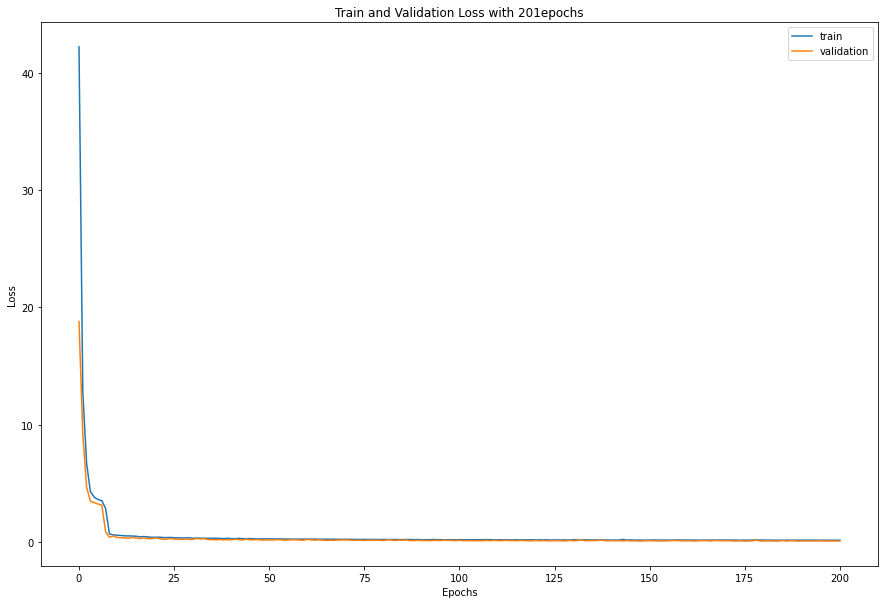

In [28]:
patience=25
# plotting training and validation history
plt.figure(figsize=(15,10))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [29]:
predict1=np.zeros((82)) #82
predict1=predictions[-3]
    
predict2=np.zeros((82))
predict2=predictions[-2]
    
predict3=np.zeros((82))
predict3=predictions[-1]

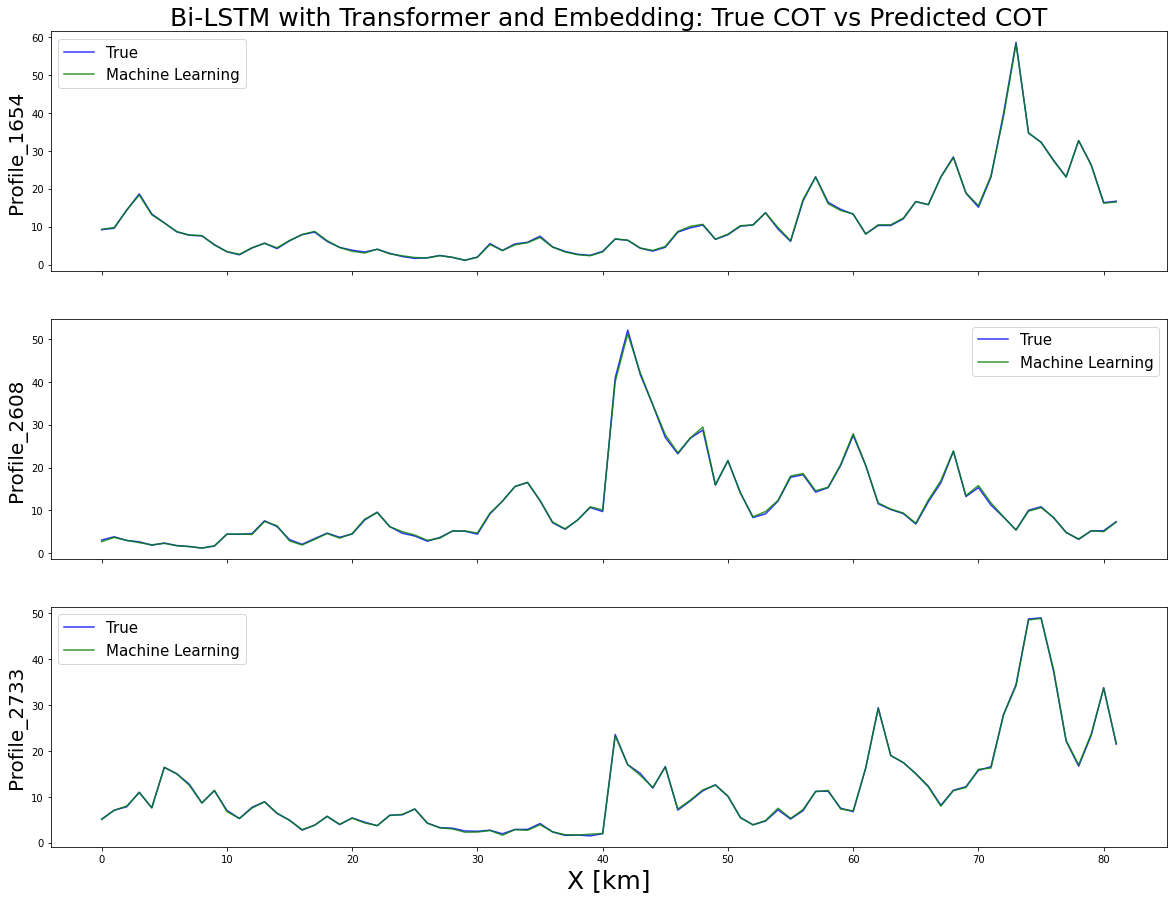

In [36]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/predict_Bi-LSTM with transformer embedding"+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM with Transformer and Embedding: True COT vs Predicted COT",fontsize=25)
ax.plot(range(82),c[num-3],alpha=0.8,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.8,color="green") 
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_1654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),c[num-2],alpha=0.8,color="blue")
ax.plot(range(82),predict2,alpha=0.8,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_2608",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),c[num-1].T,alpha=0.8,color="blue")
ax.plot(range(82),predict3,alpha=0.8,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_2733",fontsize=20)  
ax.set_xlabel('X [km]',fontsize=25)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

In [37]:
cot=np.load('cot_500m.npy')

In [32]:
for i in range(4000):
    if np.array_equal(c[num-1],cot[i]):
        print(i+1)

2733


In [33]:
for i in range(4000):
    if np.array_equal(c[num-2],cot[i]):
        print(i+1)

2608


In [34]:
for i in range(4000):
    if np.array_equal(c[num-3],cot[i]):
        print(i+1)

1654


# Plotting across predicted 82 COT values¶

In [38]:
std=[]
mean=[]

for k in range(82):#82
    tmp=[]
    for j in range(800): #test set
        tmp.append(np.abs(predictions[j][k]-test_label[j][k])) #absolute difference 
    std.append(np.std(tmp))
    mean.append(np.mean(tmp)) #### replace with RMSE 
    

std=np.array(std) #sd of the absolute difference of the 800 profiles at each cot values. 
mean=np.array(mean) #mean absolute difference between the predicted value and the orginal values of 800 profiles at each cot value
std1 = np.std(mean) #standard deviation of the mean absolute difference across the 82 cot values 

# plot std, std1
# histogram of mean and histogram of std


In [50]:
mean

array([0.22397075, 0.23180212, 0.18962095, 0.16237507, 0.18938445,
       0.18375951, 0.16522905, 0.16017073, 0.17010759, 0.15552039,
       0.20975032, 0.20222579, 0.1983857 , 0.21800414, 0.20310948,
       0.16909562, 0.18160301, 0.19320345, 0.20459151, 0.18040002,
       0.22369521, 0.195669  , 0.17015013, 0.18858973, 0.16959168,
       0.18090939, 0.19858995, 0.2159425 , 0.15526785, 0.16072318,
       0.1784705 , 0.20103065, 0.1867669 , 0.15609663, 0.16610716,
       0.18808739, 0.1691081 , 0.17763956, 0.16565354, 0.20887499,
       0.20603992, 0.24518697, 0.23120139, 0.20103401, 0.20372564,
       0.20512864, 0.1851515 , 0.18556575, 0.17753979, 0.19251218,
       0.17499145, 0.21010607, 0.1785089 , 0.17767144, 0.18780479,
       0.15684024, 0.18063395, 0.20518533, 0.20302078, 0.2198706 ,
       0.1839988 , 0.26452936, 0.23101441, 0.16773917, 0.16022868,
       0.18431044, 0.1809397 , 0.19199476, 0.18571508, 0.17184735,
       0.1627928 , 0.20855708, 0.18536195, 0.14123619, 0.18944

In [51]:
predictions.shape

(800, 82)

In [39]:
hist_m, bins_m = np.histogram(mean)
hist_s, bins_s = np.histogram(std)

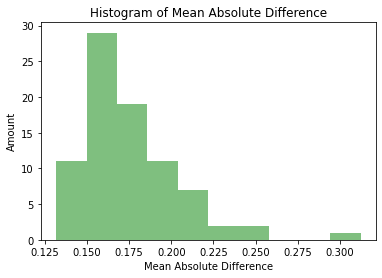

In [40]:
n, bins, patches = plt.hist(mean,bins=10,color='green',alpha=0.5)

plt.xlabel('Mean Absolute Difference')
plt.ylabel('Amount')

plt.title('Histogram of Mean Absolute Difference')

plt.show()

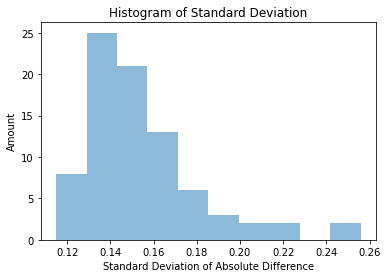

In [41]:
n, bins, patches = plt.hist(std,bins=10,histtype='bar',alpha=0.5)

plt.xlabel('Standard Deviation of Absolute Difference')
plt.ylabel('Amount')

plt.title('Histogram of Standard Deviation')

plt.show()

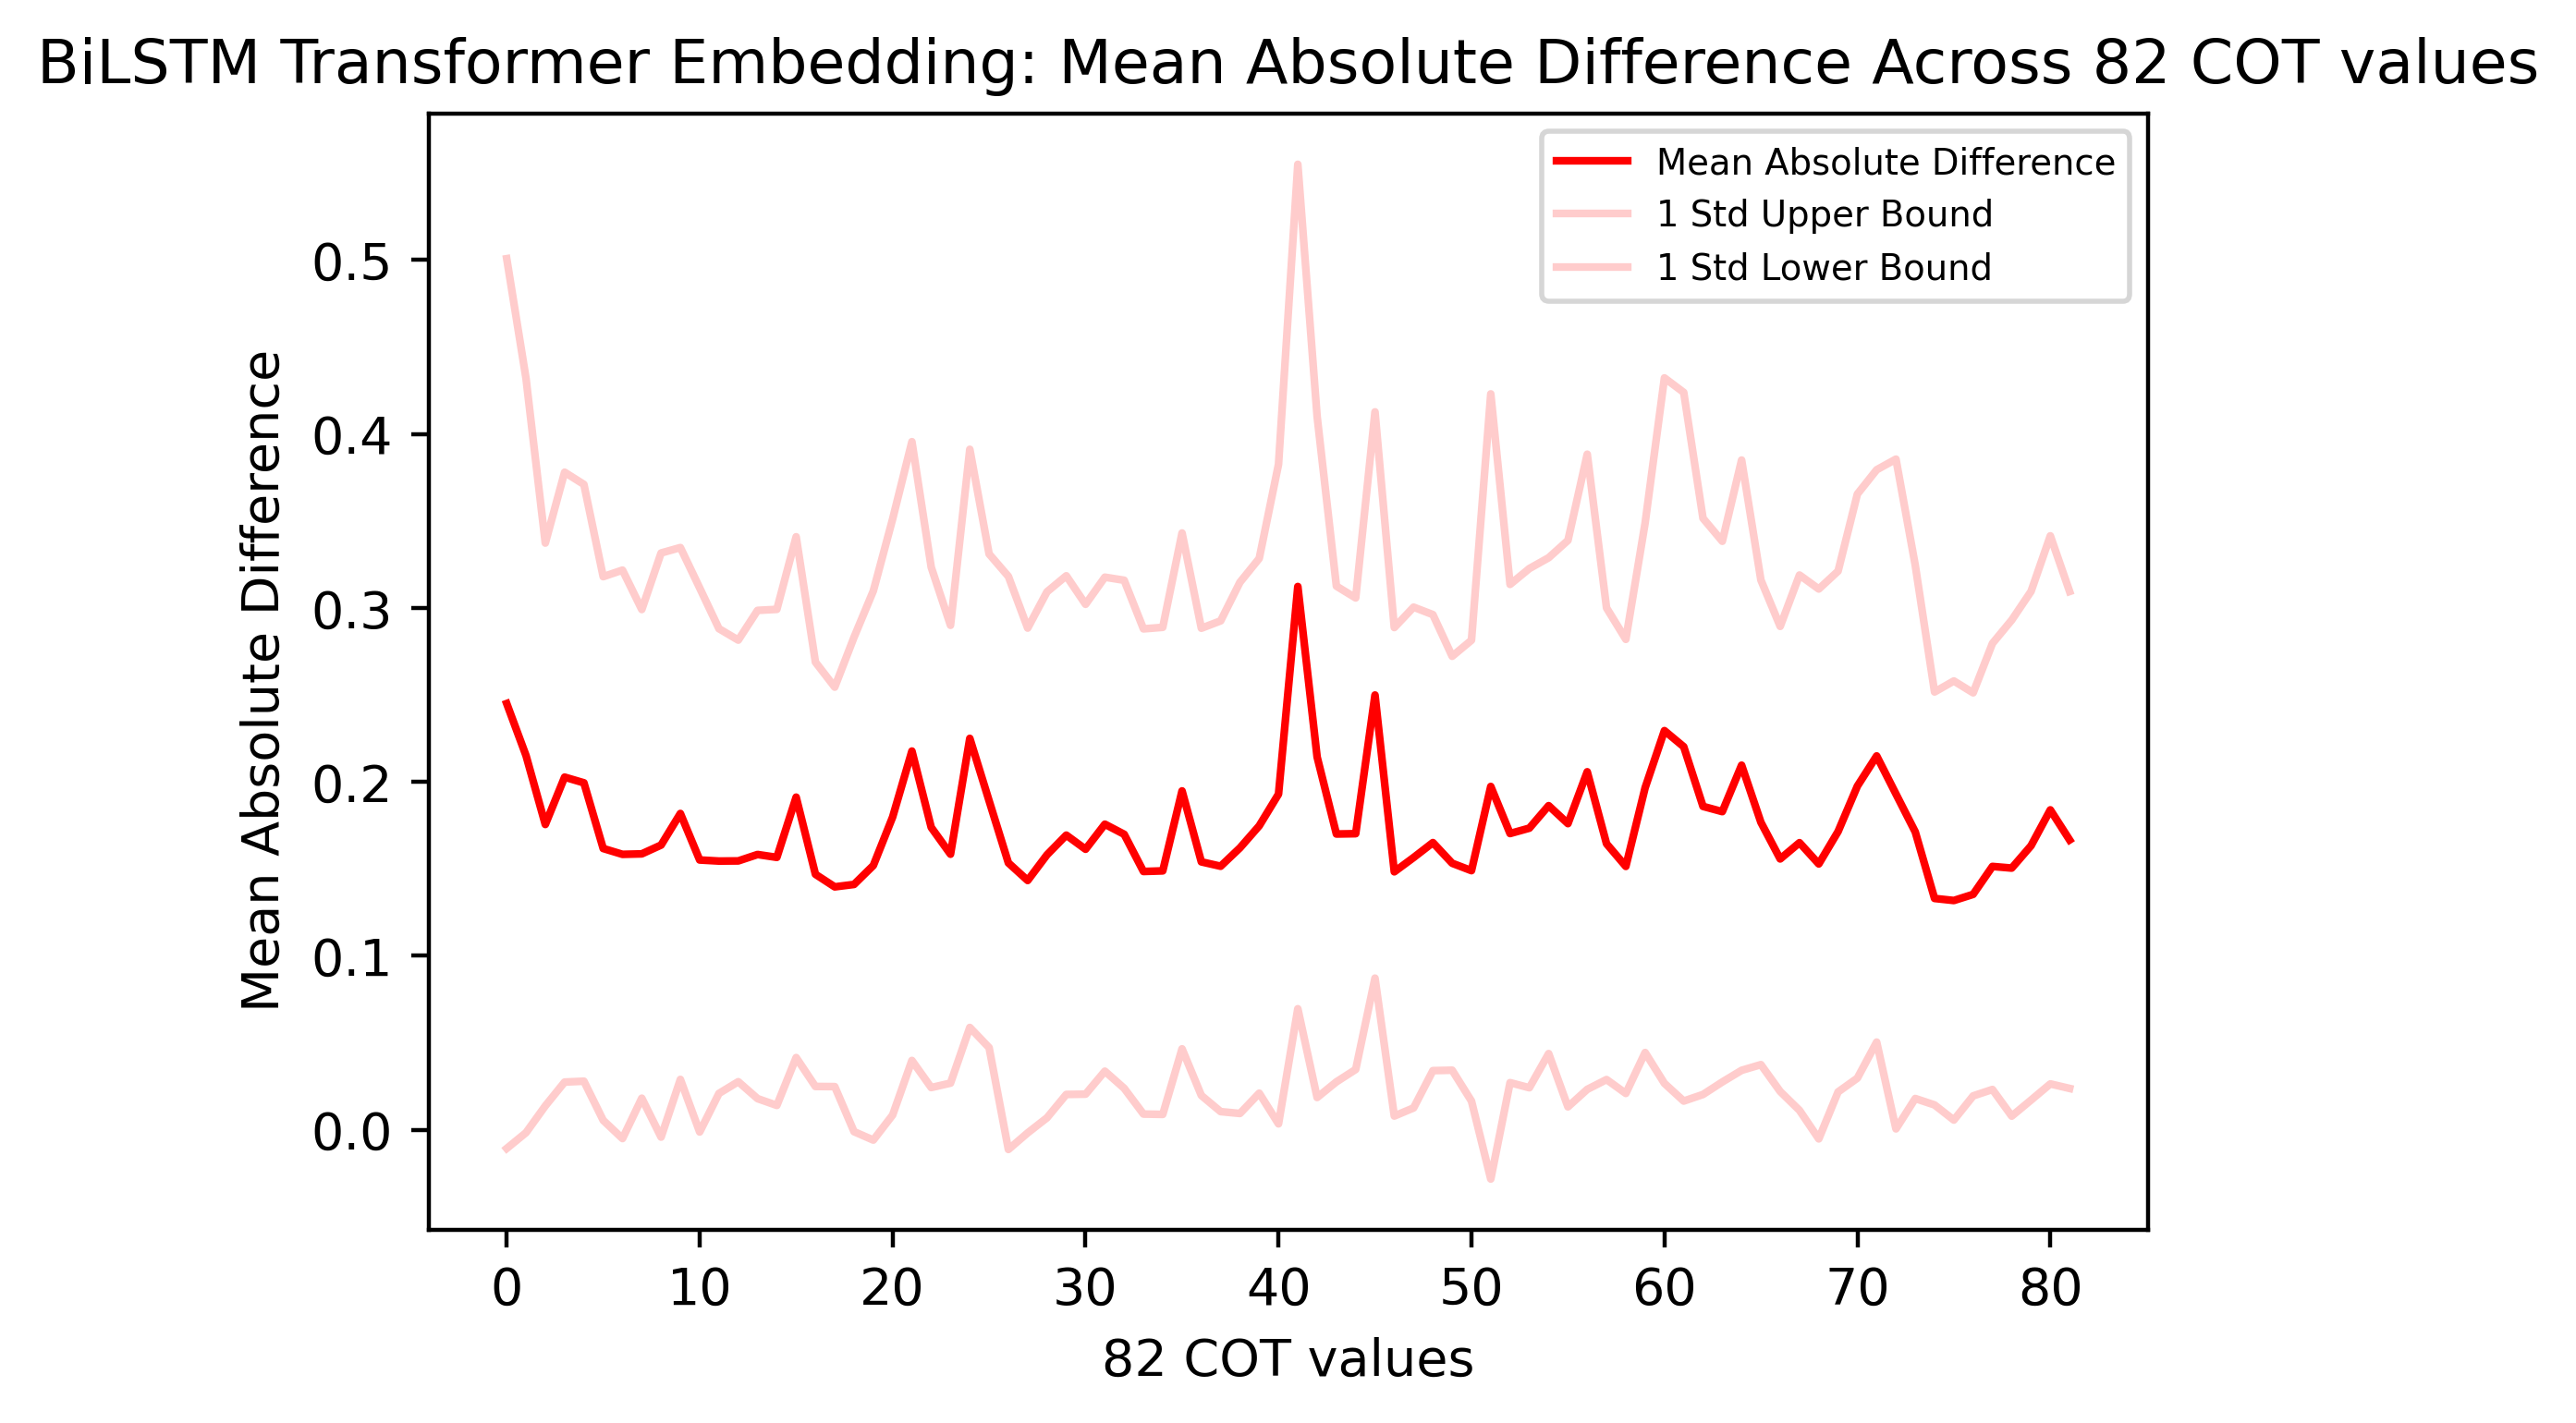

In [42]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
#ax.set_ylim((-0.5,1))
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM_with_ Transformer_Embedding_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)

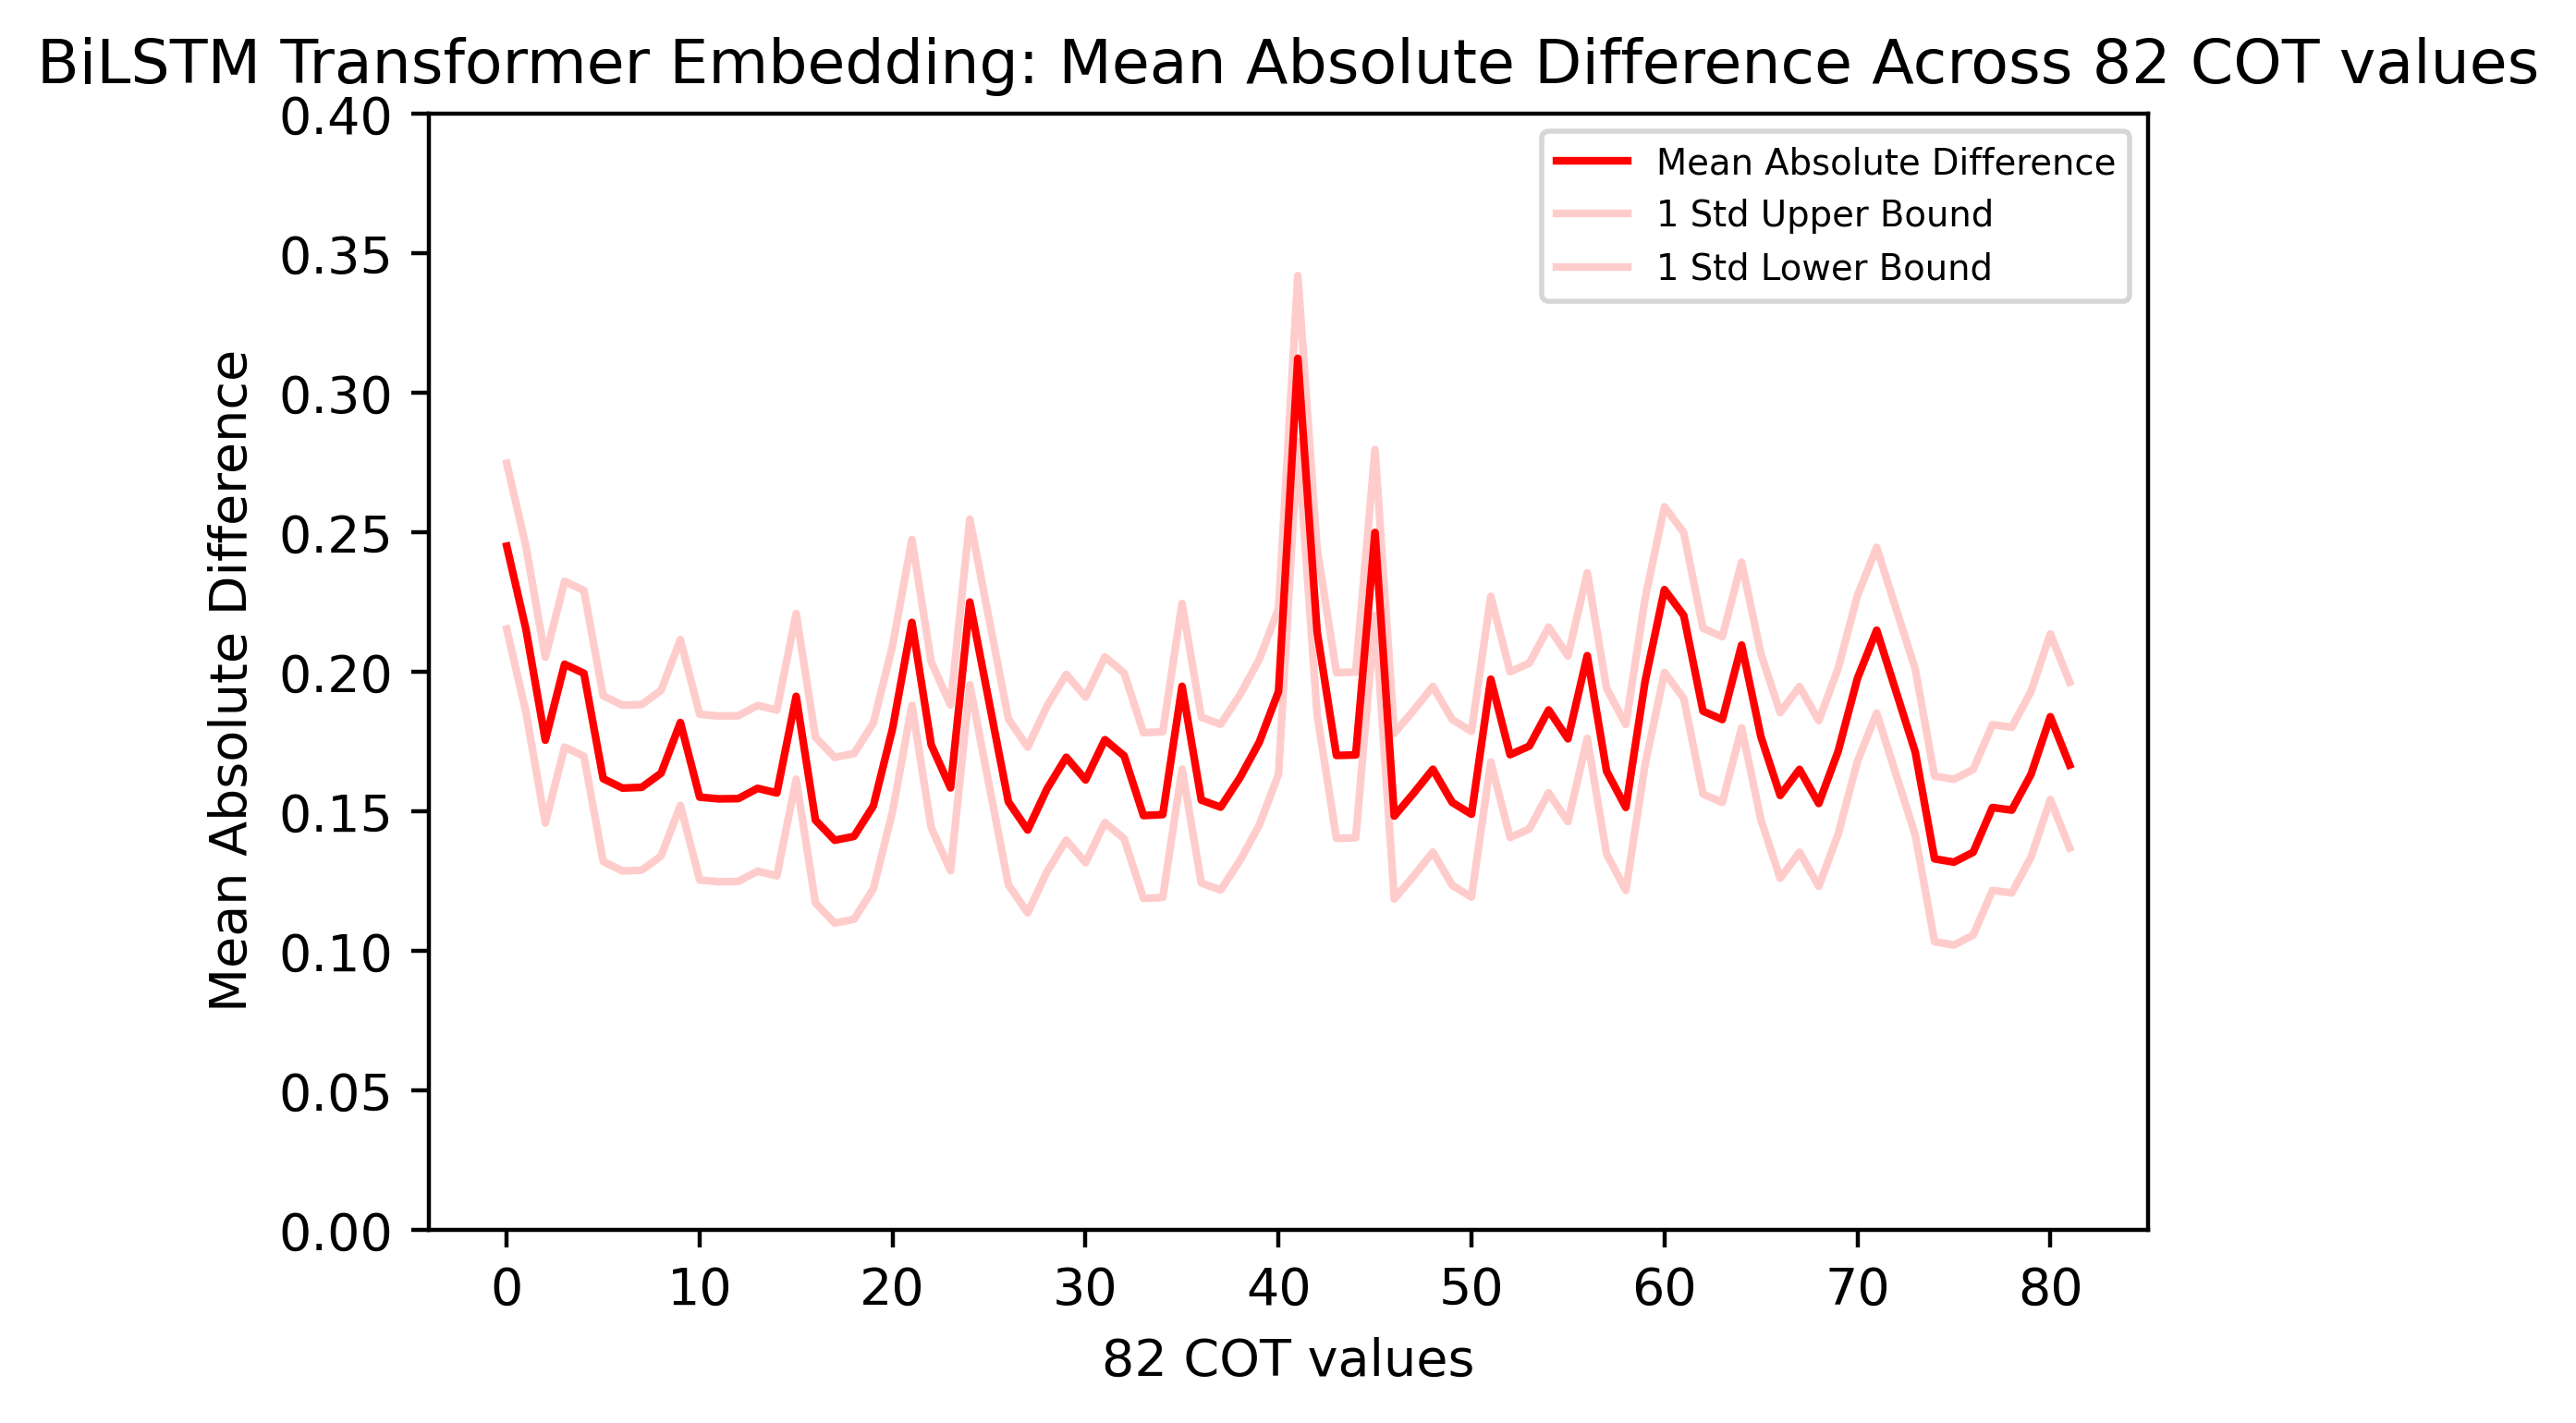

In [43]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std1, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std1, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylim((0,0.4))
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM_with_ Transformer_Embedding_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)
